In [17]:
%config Completer.use_jedi = False

In [1]:
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from IPython.display import clear_output
from pathlib import Path
from skimage.util import view_as_windows
from PIL import Image
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from tqdm import tqdm
from torchsummary import summary
from sklearn import metrics
from torchvision import transforms
import torch.nn.init as init
from matplotlib.gridspec import GridSpec

def accuracy(target, pred):
    return metrics.accuracy_score(target.detach().cpu().numpy(), pred.detach().cpu().numpy())

In [2]:
image_shape=(32, 32)
batch_size = 64

import torchvision.transforms as transforms
from PIL import Image

class CustomDataset(Dataset):
    def __init__(self, data_paths, label_paths, image_shape=(64, 64), step=None, transform=None):
        self.image_paths = list(data_paths)
        self.label_paths = list(label_paths)
        self.image_shape = image_shape
        self.step = self.image_shape[0]
        if step is not None:
            self.step = step
        self.data = self._load()
        self.transform = transform
        
    def _load(self):
        data = []
        for img_path, label_path in zip(self.image_paths, self.label_paths):
            img = np.array(Image.open(img_path))
            label = np.array(Image.open(label_path))
            label[label == 0] = 2
            label[label == 128] = 0
            label[label == 255] = 1
            img = img.astype(np.int16)
            label = label.astype(np.uint8)

            img_patches = view_as_windows(img, self.image_shape, step=self.step)
            label_patches = view_as_windows(label, self.image_shape, step=self.step)

            img_patches = img_patches.reshape(-1, 1, *self.image_shape)
            label_patches = label_patches.reshape(-1, *self.image_shape)

            data.extend(list(zip(img_patches, label_patches)))

        return data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img, label = self.data[idx]
        
        # Convert to PyTorch tensors
        img = torch.from_numpy(img).float()
        label = torch.from_numpy(label).long()

        # Apply transformations
        if self.transform:
            img = self.transform(img)
            
        return img, label

# Transformations
data_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(degrees=30),
    transforms.ToTensor(),
])

# loading the dataset
data_dir = Path('training_dataset/')
data_paths = (data_dir / 'data').glob('*.tiff')
data_paths = list(data_paths)[:-20]
label_paths = (data_dir / 'labels').glob('*.tif')
label_paths = list(label_paths)[:-20]


dataset = CustomDataset(data_paths, label_paths, image_shape=image_shape)
# Define the ratio of data to be used for testing (e.g., 20%)
test_ratio = 0.2

# Calculate the number of samples for the test set
num_samples = len(dataset)
num_test_samples = int(test_ratio * num_samples)
# num_valid_samples = int(test_ratio * num_samples)
num_train_samples = num_samples - num_test_samples #- num_valid_samples

# Use random_split to create training and test datasets
# train_dataset, test_dataset, valid_dataset = random_split(dataset, [num_train_samples, num_test_samples, num_valid_samples])
train_dataset, test_dataset = random_split(dataset, [num_train_samples, num_test_samples])

# Create DataLoader instances for training and testing
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)
# valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)

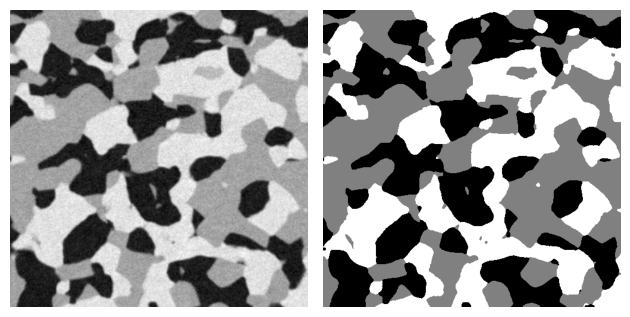

In [4]:
# Create a figure with two subplots vertically
fig, axs = plt.subplots(1, 2,) #figsize=(6, 8))

# Plot the first image in the first subplot
axs[0].imshow(Image.open(data_dir/'data'/'SOCprist0001.tiff'), cmap='gray')
axs[0].axis('off')  # Optional: Turn off axis labels

# Plot the second image in the second subplot
axs[1].imshow(Image.open(data_dir/'labels'/'slice__001.tif'), cmap='gray')
axs[1].axis('off')  # Optional: Turn off axis labels

# Adjust layout to prevent overlap
# fig.suptitle('Training data and corresponding label', y=0.81)
plt.tight_layout()


# Show the plot
# plt.show()
plt.savefig('data_label.png')

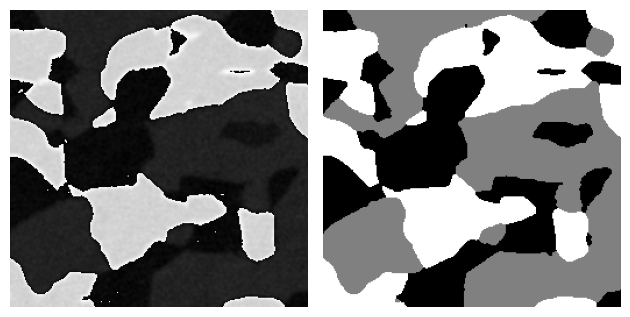

In [5]:
# Create a figure with two subplots vertically
fig, axs = plt.subplots(1, 2,) #figsize=(6, 8))

# Plot the first image in the first subplot
axs[0].imshow(train_dataset.dataset.data[1][0][0], cmap='gray')
axs[0].axis('off')  # Optional: Turn off axis labels

# Plot the second image in the second subplot
axs[1].imshow(train_dataset.dataset.data[1][1], cmap='gray')
axs[1].axis('off')  # Optional: Turn off axis labels

# Adjust layout to prevent overlap
# fig.suptitle('Training data and corresponding label', y=0.81)
plt.tight_layout()


# Show the plot
# plt.show()
plt.savefig('patches.png')

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import Parameter

class simple_dense(nn.Module):
    def __init__(self, num_features, num_hidden, classes):
        super(simple_dense, self).__init__()  
        # input layer
        self.W_1 = Parameter(nn.init.xavier_normal_(torch.Tensor(num_hidden, num_features)))
        self.b_1 = Parameter(nn.init.constant_(torch.Tensor(num_hidden), 0))
        self.bn_1 = nn.BatchNorm1d(num_hidden)
        # hidden layer
        self.W_2 = Parameter(nn.init.xavier_normal_(torch.Tensor(num_hidden, num_hidden)))
        self.b_2 = Parameter(nn.init.constant_(torch.Tensor(num_hidden), 0))
        self.bn_2 = nn.BatchNorm1d(num_hidden)
        # define activation function in constructor
        self.W_3 = Parameter(nn.init.xavier_normal_(torch.Tensor(num_features*classes, num_hidden)))
        self.b_3 = Parameter(nn.init.constant_(torch.Tensor(num_features*classes), 0))
        self.activation = nn.ReLU()

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = F.linear(x, self.W_1, self.b_1)
        x = self.bn_1(x)
        x = self.activation(x)
        x = F.linear(x, self.W_2, self.b_2)
        x = self.bn_2(x)
        x = self.activation(x)
        x = F.linear(x, self.W_3, self.b_3)
        x = x.view(-1, 3, image_shape[0], image_shape[1])  # Reshape to the desired image dimensions
        return x


# Initialize the model, loss function, and optimizer
model = simple_dense(num_features=image_shape[0]**2, num_hidden=128, classes=3)
device = torch.device('cuda')
model.to(device)
criterion = nn.CrossEntropyLoss()  # Binary Cross Entropy Loss for binary segmentation
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.001)

In [4]:
# Define U-Net architecture for grayscale images
class UNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNet, self).__init__()

        # convolution blocks
        self.conv1 = self.conv_block(in_channels, 32)
        self.conv2 = self.conv_block(32, 64)
        self.conv3 = self.conv_block(64, 128)
        self.conv4 = self.conv_block(128, 256)
        # encoding block
        self.enc = self.encoder_block()
        # bridge
        self.bridge = self.conv_block(256, 512)
        # decoder blocks 
        self.upconv1 = self.decoder_block(512, 256)
        self.conv5 = self.conv_block(512, 256)
        self.upconv2 = self.decoder_block(256, 128)
        self.conv6 = self.conv_block(256, 128)
        self.upconv3 = self.decoder_block(128, 64)
        self.conv7 = self.conv_block(128, 64)
        self.upconv4 = self.decoder_block(64, 32)
        self.conv8 = self.conv_block(64, 32)

        # Output layer
        self.outconv = nn.Sequential(
            nn.Conv2d(32, out_channels, kernel_size=1),
            nn.Sigmoid()
        )
        
        self.apply(self.initialize_weights)

    def initialize_weights(self, m):
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
            init.xavier_uniform_(m.weight)
            if m.bias is not None:
                init.zeros_(m.bias)
        elif isinstance(m, nn.BatchNorm2d):
            init.ones_(m.weight)
            init.zeros_(m.bias)

    def conv_block(self, in_channels, out_channels, kernel_size=3):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def encoder_block(self):
        return nn.Sequential(
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

    def decoder_block(self, in_channels, out_channels):
        return nn.Sequential(
            # nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        
        conv1 = self.conv1(x)
        enc1 = self.enc(conv1)
        conv2 = self.conv2(enc1)
        enc2 = self.enc(conv2)
        conv3 = self.conv3(enc2)
        enc3 = self.enc(conv3)
        conv4 = self.conv4(enc3)
        enc4 = self.enc(conv4)
        
        bridge = self.bridge(enc4)
        upconv1 = self.upconv1(bridge)
        
        conv5 = self.conv5(torch.cat([upconv1, conv4], dim=1))
        upconv2 = self.upconv2(conv5)
        conv6 = self.conv6(torch.cat([upconv2, conv3], dim=1))
        upconv3 = self.upconv3(conv6)
        conv7 = self.conv7(torch.cat([upconv3, conv2], dim=1))
        upconv4 = self.upconv4(conv7)
        conv8 = self.conv8(torch.cat([upconv4, conv1], dim=1))
        
        output = self.outconv(conv8)
        self.dropout = nn.Dropout(p=0.2)
        output = output.squeeze(dim=1)

        return output
# 
# Initialize the model, loss function, and optimizer
model = UNet(in_channels=1, out_channels=3)# Adjust in_channels and out_channels based on your data
device = torch.device('cuda')  # use cuda or cpu
model.to(device)
# input_data = torch.randn((1, 1, *image_shape)).to(device)
# Use torchsummary to get the summary
summary(model, input_size=(1, *image_shape))

criterion = nn.CrossEntropyLoss()  # Binary Cross Entropy Loss for binary segmentation
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.001)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 256, 256]             320
       BatchNorm2d-2         [-1, 32, 256, 256]              64
              ReLU-3         [-1, 32, 256, 256]               0
            Conv2d-4         [-1, 32, 256, 256]           9,248
       BatchNorm2d-5         [-1, 32, 256, 256]              64
              ReLU-6         [-1, 32, 256, 256]               0
         MaxPool2d-7         [-1, 32, 128, 128]               0
            Conv2d-8         [-1, 64, 128, 128]          18,496
       BatchNorm2d-9         [-1, 64, 128, 128]             128
             ReLU-10         [-1, 64, 128, 128]               0
           Conv2d-11         [-1, 64, 128, 128]          36,928
      BatchNorm2d-12         [-1, 64, 128, 128]             128
             ReLU-13         [-1, 64, 128, 128]               0
        MaxPool2d-14           [-1, 64,

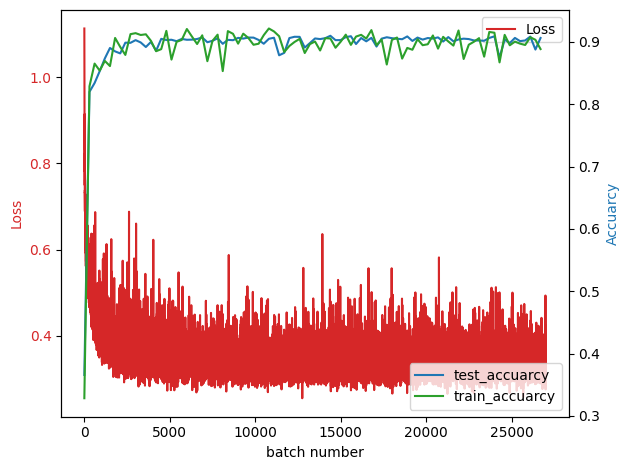

epoch no 20 of 20
Step 27000   training accuracy: 0.899
             test accuracy:     0.906
             Loss:              0.324
Finished training.


In [4]:
num_epochs = 20
validation_every_steps = 300

step = 0
model.train()

train_accuracies = []
train_accuracies_plot = []
valid_accuracies = []
train_iter = []
train_iter_acc = []
valid_iter_acc = []
train_loss_plot = []

for epoch in tqdm(range(num_epochs)):
    
    train_accuracies_batches = []
    
    for batch_idx, (inputs, targets) in enumerate(train_dataloader):
        inputs, targets = inputs.to(device), targets.to(device)
        
        # Forward pass, compute gradients, perform one training step.
        optimizer.zero_grad()
        output = model(inputs)
        loss = criterion(output, targets)
        loss.backward()
        optimizer.step()
        
        # Increment step counter
        step += 1
        
        # Compute accuracy.
        predictions = output.max(1)[1]
        train_accuracies_batches.append(accuracy(targets.flatten(), predictions.flatten()))
        train_iter.append(batch_idx+epoch*len(train_dataloader))
        train_loss_plot.append(loss.item()) 
    
        if step % validation_every_steps == 1:
            # plt.subplot(1, 2, 1)
            clear_output(wait=True)

            # Append average training accuracy to list.
            train_accuracies.append(np.mean(train_accuracies_batches))
            
            # train_accuracies_batches = []
        
            # Compute accuracies on validation set.
            valid_accuracies_batches = []
            with torch.no_grad():
                model.eval()
                for inputs, targets in test_dataloader:
                    inputs, targets = inputs.to(device), targets.to(device)
                    output = model(inputs)
                    loss = criterion(output, targets)

                    predictions = output.max(1)[1]

                    # Multiply by len(x) because the final batch of DataLoader may be smaller (drop_last=False).
                    valid_accuracies_batches.append(accuracy(targets.flatten(), predictions.flatten()) * len(inputs))

                model.train()
                
            # Append average validation accuracy to list.
            valid_accuracies.append(np.sum(valid_accuracies_batches) / len(test_dataset))
            valid_iter_acc.append(batch_idx+epoch*len(train_dataloader))
            train_accuracies_plot.append(train_accuracies_batches[-1])
            train_iter_acc.append(batch_idx+epoch*len(train_dataloader))




            # plottinog
            fig, ax1 = plt.subplots()
            color = 'tab:red'
            ax1.set_xlabel('batch number')
            ax1.set_ylabel('Loss', color=color)
            ax1.plot(train_iter, train_loss_plot, color=color, label='Loss')
            ax1.tick_params(axis='y', labelcolor=color)
            ax1.legend()
            ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
            color = 'tab:blue'
            ax2.set_ylabel('Accuarcy', color=color)  # we already handled the x-label with ax1
            ax2.tick_params(axis='y')
            ax2.plot(valid_iter_acc, valid_accuracies, color=color, label='test_accuarcy')
            ax2.plot(train_iter_acc, train_accuracies_plot, color='tab:green', label='train_accuarcy')
            ax2.legend()
            fig.tight_layout()  # otherwise the right y-label is slightly clipped
            plt.show()
            print(f'epoch no {epoch+1} of {num_epochs}')
            print(f"Step {step:<5}   training accuracy: {train_accuracies[-1]:.3f}")
            print(f"             test accuracy:     {valid_accuracies[-1]:.3f}")
            print(f"             Loss:              {train_loss_plot[-1]:.3f}")

clear_output(wait=True)
fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.set_xlabel('batch number')
ax1.set_ylabel('Loss', color=color)
ax1.plot(train_iter, train_loss_plot, color=color, label='Loss')
ax1.tick_params(axis='y', labelcolor=color)
ax1.legend()
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
ax2.set_ylabel('Accuarcy', color=color)  # we already handled the x-label with ax1
ax2.tick_params(axis='y')
ax2.plot(valid_iter_acc, valid_accuracies, color=color, label='test_accuarcy')
ax2.plot(train_iter_acc, train_accuracies_plot, color='tab:green', label='train_accuarcy')
ax2.legend()
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()
print(f'epoch no {epoch+1} of {num_epochs}')
print(f"Step {step:<5}   training accuracy: {train_accuracies[-1]:.3f}")
print(f"             test accuracy:     {valid_accuracies[-1]:.3f}")
print(f"             Loss:              {train_loss_plot[-1]:.3f}")
print("Finished training.")

In [6]:
# torch.save(model, 'unet')
model = torch.load('unet')
model.eval()

UNet(
  (conv1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_runn

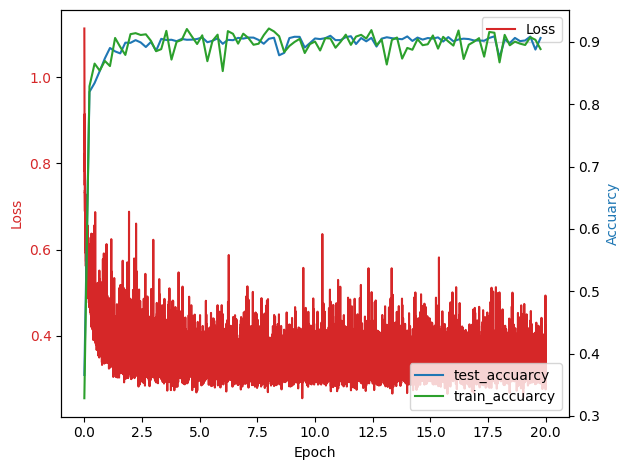

In [5]:
fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss', color=color)
ax1.plot([a/len(train_dataloader) for a in train_iter], train_loss_plot, color=color, label='Loss')
ax1.tick_params(axis='y', labelcolor=color)
ax1.legend()
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
ax2.set_ylabel('Accuarcy', color=color)  # we already handled the x-label with ax1
ax2.tick_params(axis='y')
ax2.plot([a/len(train_dataloader) for a in valid_iter_acc], valid_accuracies, color=color, label='test_accuarcy')
ax2.plot([a/len(train_dataloader) for a in train_iter_acc], train_accuracies_plot, color='tab:green', label='train_accuarcy')
ax2.legend()
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.savefig('dense_training.png')

In [6]:
sum(p.numel() for p in model.parameters())

544512

In [205]:
# sum(p.numel() for p in model.parameters())
print('Number of parameters for model with 32x32 patch is 544512')

Number of parameters for model with 32x32 patch is 544512


# Classify an entire image

In [7]:
def classify_image(model, image_name, image_shape=image_shape):
    data_paths = (data_dir / 'data').glob(f'*{image_name}.tiff')
    label_paths = (data_dir / 'labels').glob(f'*{image_name}.tif')

    one_image_dataset = CustomDataset(data_paths, label_paths, image_shape=image_shape, step=1)
    one_image = DataLoader(one_image_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)
    
    model.eval()
    classified_image = []
    target_image = []
    with torch.no_grad():
        for inputs, targets in one_image:
            # Perform any necessary pre-processing on inputs and targets
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)+1
            classified_image.append((outputs.max(1)[1].cpu()+1).to(torch.uint8))  # Assuming outputs is on GPU
            target_image.append((targets.cpu()+1).to(torch.uint8))
    # Concatenate the list of output tensors along the batch dimension
    classified_image = torch.cat(classified_image, dim=0)
    target_image = torch.cat(target_image, dim=0)
    return classified_image, target_image

In [8]:
def prettify(image):
    temp = image.copy()
    temp[image==2] = 2
    temp[image==1] = 1
    temp[image==3] = 0
    return temp

In [11]:
image_name = '001'   
classified_image, target_image = classify_image(model, image_name)


# Size parameters
canvas_size = 501
sub_image_size = image_shape[0]
stride = 1

# Calculate the number of sub-images and the size of the canvas along the third dimension
num_sub_images = (canvas_size - sub_image_size) // stride + 1
canvas_depth = num_sub_images * num_sub_images

# Create random sub-images for illustration
# sub_images = np.random.randint(0, 255, size=(sub_image_size, sub_image_size, canvas_depth), dtype=np.uint8)

# Initialize the canvas
canvas = np.zeros((canvas_size, canvas_size, canvas_depth), dtype=np.uint8)

# Assign sub-images to their respective positions
for i in range(num_sub_images):
    for j in range(num_sub_images):
        canvas[i:i+sub_image_size, j:j+sub_image_size, i*num_sub_images+j] = classified_image[i*num_sub_images+j, :, :]

# Display the resulting canvas
# print(canvas)
classified_image = canvas.max(axis=2)
del canvas
canvas = np.zeros((canvas_size, canvas_size, canvas_depth), dtype=np.uint8)

# Assign sub-images to their respective positions
for i in range(num_sub_images):
    for j in range(num_sub_images):
        canvas[i:i+sub_image_size, j:j+sub_image_size, i*num_sub_images+j] = target_image[i*num_sub_images+j, :, :]

# Display the resulting canvas
# print(canvas)
target_image = canvas.max(axis=2)
del canvas

# Image 1 (seen data)

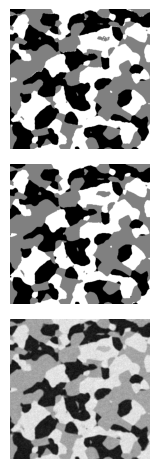

In [12]:
# Create a figure with two subplots vertically
fig, axs = plt.subplots(3, 1,) #figsize=(6, 8))

# Plot the first image in the first subplot
axs[0].imshow(prettify(classified_image), cmap='gray')
axs[0].axis('off')  # Optional: Turn off axis labels

# Plot the second image in the second subplot
axs[1].imshow(prettify(target_image), cmap='gray')
axs[1].axis('off')  # Optional: Turn off axis labels

# Plot the third image in the second subplot
axs[2].imshow(Image.open(next((data_dir / 'data').glob(f'*{image_name}.tiff'))), cmap='gray')
axs[2].axis('off')  # Optional: Turn off axis labels

# Adjust layout to prevent overlap
# fig.suptitle('Training data and corresponding label', y=0.81)
plt.tight_layout()


# Show the plot
# plt.show()
plt.savefig('seen_data2.png', bbox_inches='tight')

In [13]:
metrics.accuracy_score(target_image.flatten(),classified_image.flatten())

0.9648208572874212

# image 500 (unseen data)

In [9]:
image_name = '500'   
classified_image, target_image = classify_image(model, image_name)


# Size parameters
canvas_size = 501
sub_image_size = image_shape[0]
stride = 1

# Calculate the number of sub-images and the size of the canvas along the third dimension
num_sub_images = (canvas_size - sub_image_size) // stride + 1
canvas_depth = num_sub_images * num_sub_images

# Create random sub-images for illustration
# sub_images = np.random.randint(0, 255, size=(sub_image_size, sub_image_size, canvas_depth), dtype=np.uint8)

# Initialize the canvas
canvas = np.zeros((canvas_size, canvas_size, canvas_depth), dtype=np.uint8)

# Assign sub-images to their respective positions
for i in range(num_sub_images):
    for j in range(num_sub_images):
        canvas[i:i+sub_image_size, j:j+sub_image_size, i*num_sub_images+j] = classified_image[i*num_sub_images+j, :, :]

# Display the resulting canvas
# print(canvas)
classified_image = canvas.max(axis=2)
del canvas
canvas = np.zeros((canvas_size, canvas_size, canvas_depth), dtype=np.int8)

# Assign sub-images to their respective positions
for i in range(num_sub_images):
    for j in range(num_sub_images):
        canvas[i:i+sub_image_size, j:j+sub_image_size, i*num_sub_images+j] = target_image[i*num_sub_images+j, :, :]

# Display the resulting canvas
# print(canvas)
target_image = canvas.max(axis=2)
del canvas

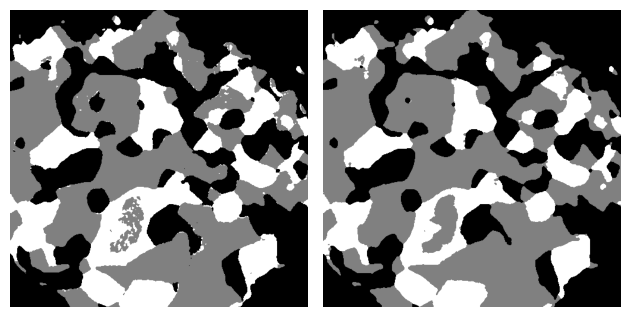

In [15]:
# Create a figure with two subplots vertically
fig, axs = plt.subplots(1, 2) #figsize=(6, 8))

# Plot the first image in the first subplot
axs[0].imshow(prettify(classified_image), cmap='gray')
axs[0].axis('off')  # Optional: Turn off axis labels

# Plot the second image in the second subplot
axs[1].imshow(prettify(target_image), cmap='gray')
axs[1].axis('off')  # Optional: Turn off axis labels

# Plot the third image in the second subplot
# axs[2].imshow(Image.open(next((data_dir / 'data').glob(f'*{image_name}.tiff'))), cmap='gray')
# axs[2].axis('off')  # Optional: Turn off axis labels

# Adjust layout to prevent overlap
# fig.suptitle('Training data and corresponding label', y=0.81)
plt.tight_layout()


# Show the plot
# plt.show()
plt.savefig('unseen_data2.png', bbox_inches='tight')

In [14]:
metrics.accuracy_score(target_image.flatten(),classified_image.flatten())

0.9504065720853702

In [8]:
image_name = '500'   

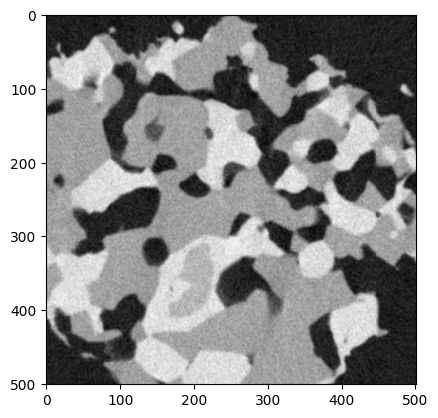

In [9]:
plt.imshow(Image.open(next((data_dir / 'data').glob(f'*{image_name}.tiff'))), cmap='gray')
plt.savefig('pic500.png', bbox_inches='tight')